<a href="https://colab.research.google.com/github/MuhammadToqeer/trrafic-signs-recognition/blob/mt_development_v1/Traffic_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report

V3

In [ ]:
# Function to load images and labels
def load_images(data_dir, labels_df):
    data = []
    labels = []

    for class_id in range(len(labels_df)):
        folder_path = os.path.join(data_dir, str(class_id))
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to uniform size
                data.append(img)
                labels.append(class_id)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [ ]:
# Define YOLOv3 blocks
def yolo_conv_block(x, filters):
    x = layers.Conv2D(filters, (1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D(filters * 2, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    return x

In [ ]:
# Build YOLOv3 baseline architecture
def yolo_v3_baseline(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 128)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # YOLO typically has multiple detection layers, but we’ll keep it simple for this POC
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
# Add more YOLO layers and tune architecture
def yolo_v3_fine_tuned(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Add more layers
    x = yolo_conv_block(x, 256)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
# Load the labels.csv file
labels_df = pd.read_csv('/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/labels.csv')
print(labels_df.head())  # Check if labels are loaded correctly

   ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)


In [ ]:
# Path to dataset directory
data_dir = '/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/DATA'

# Define image size
IMG_SIZE = 224  # Adjust as needed

# Load dataset
X, y = load_images(data_dir, labels_df)

# Check dataset shape
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

Data shape: (4054, 224, 224, 3), Labels shape: (4054,)


In [ ]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 3243, Testing samples: 811


In [ ]:
# Initialize YOLOv3 baseline
model = yolo_v3_baseline((IMG_SIZE, IMG_SIZE, 3), num_classes=len(labels_df))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Visualize the model architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 103,180,536 (393.60 MB)

 Trainable params: 103,179,384 (393.60 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Fit the model on augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=20)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 58s 389ms/step - accuracy: 0.1783 - loss: 100.2999 - val_accuracy: 0.0493 - val_loss: 19.0013
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step - accuracy: 0.3325 - loss: 11.9731 - val_accuracy: 0.0321 - val_loss: 11.1810
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step - accuracy: 0.4584 - loss: 5.1088 - val_accuracy: 0.0666 - val_loss: 8.0350
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.5337 - loss: 2.5903 - val_accuracy: 0.2219 - val_loss: 6.6238
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 0.5617 - loss: 2.5904 - val_accuracy: 0.4846 - val_loss: 3.1805
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 282ms/step - accuracy: 0.5983 - loss: 2.0783 - val_accuracy: 0.6289 - val_loss: 1.7557
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - accuracy: 0.6409 - loss: 1.7361 - val_accuracy: 0.6905 - val_loss: 1.3010
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.6590 - lo

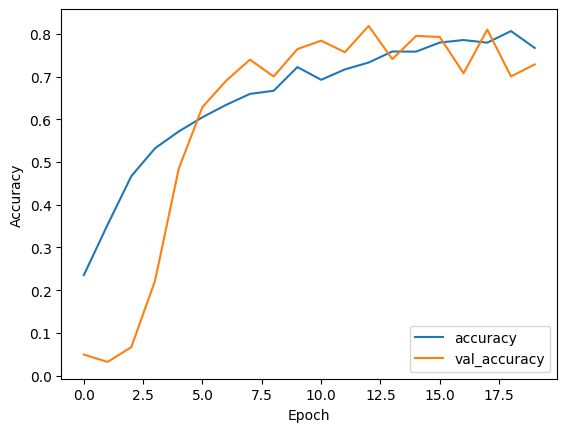

In [ ]:
# Visualize training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

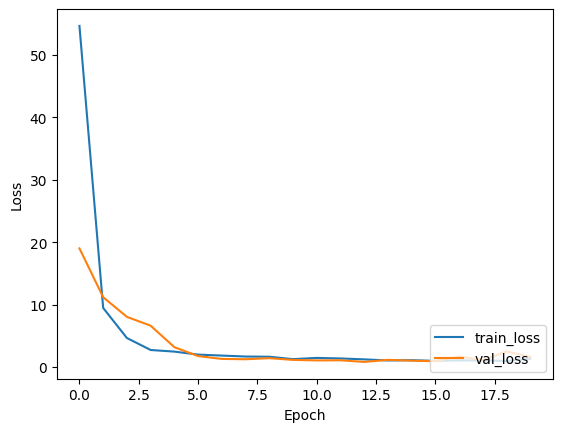

In [ ]:
# Visualize loss  history

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save fine-tuned YOLOv3 model
model.save('/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/yolov3_model.h5')

In [ ]:

# Initialize fine-tuned YOLOv3
model_finetuned = yolo_v3_fine_tuned((IMG_SIZE, IMG_SIZE, 3), num_classes=len(labels_df))

# Compile and train
model_finetuned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with fine-tuned model
history_finetuned = model_finetuned.fit(datagen.flow(X_train, y_train, batch_size=32),
                                        validation_data=(X_test, y_test),
                                        epochs=30)

# Evaluate performance
test_loss, test_acc = model_finetuned.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 403ms/step - accuracy: 0.1806 - loss: 164.0169 - val_accuracy: 0.0678 - val_loss: 20.1410
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.3591 - loss: 15.2156 - val_accuracy: 0.1233 - val_loss: 16.8488
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 295ms/step - accuracy: 0.4463 - loss: 9.3679 - val_accuracy: 0.1554 - val_loss: 13.5399
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.5191 - loss: 6.0587 - val_accuracy: 0.2898 - val_loss: 8.1920
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.5640 - loss: 4.5848 - val_accuracy: 0.4649 - val_loss: 4.4936
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.6237 - loss: 3.3749 - val_accuracy: 0.5697 - val_loss: 3.2702
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 300ms/step - accuracy: 0.6146 - loss: 2.8911 - val_accuracy: 0.6991 - val_loss: 2.3711
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.6747 - l

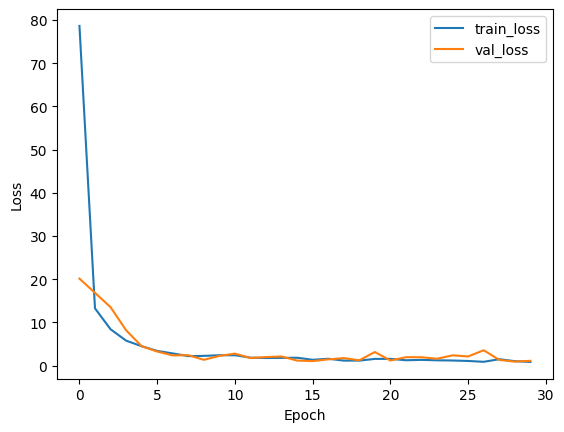

In [ ]:
plt.plot(history_finetuned.history['loss'], label='train_loss')
plt.plot(history_finetuned.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Save fine-tuned YOLOv3 model
model_finetuned.save('/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/yolov3_finetuned_model.h5')

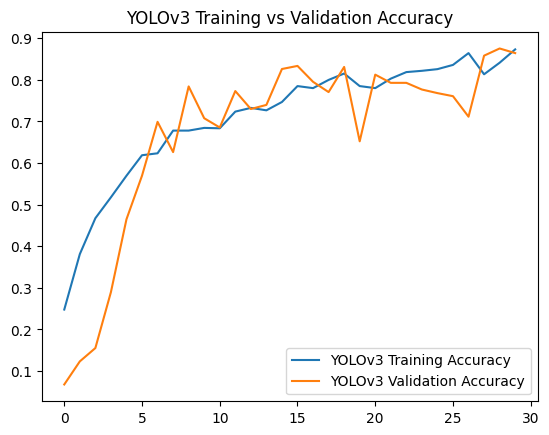

In [ ]:
plt.plot(history_finetuned.history['accuracy'], label='YOLOv3 Training Accuracy')
plt.plot(history_finetuned.history['val_accuracy'], label='YOLOv3 Validation Accuracy')
plt.title('YOLOv3 Training vs Validation Accuracy')
plt.legend()
plt.show()

**V5**

In [ ]:
# YOLOv5 architecture (simplified)
def yolo_v5_baseline(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 128)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # YOLOv5 typically has more depth and layers compared to v3
    x = yolo_conv_block(x, 256)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
# Initialize YOLOv5 baseline
model_v5 = yolo_v5_baseline((IMG_SIZE, IMG_SIZE, 3), num_classes=len(labels_df))

In [ ]:
# Compile the model
model_v5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the YOLOv5 model
history_v5 = model_v5.fit(datagen.flow(X_train, y_train, batch_size=32),
                          validation_data=(X_test, y_test),
                          epochs=20)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 360ms/step - accuracy: 0.1536 - loss: 62.8182 - val_accuracy: 0.0592 - val_loss: 4.5104
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step - accuracy: 0.3489 - loss: 3.4742 - val_accuracy: 0.0974 - val_loss: 4.3221
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.4231 - loss: 2.4758 - val_accuracy: 0.0851 - val_loss: 4.3227
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 0.4908 - loss: 2.2006 - val_accuracy: 0.2626 - val_loss: 2.8204
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.5633 - loss: 1.7345 - val_accuracy: 0.3970 - val_loss: 2.4574
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 282ms/step - accuracy: 0.6162 - loss: 1.5665 - val_accuracy: 0.6017 - val_loss: 1.7101
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.6338 - loss: 1.6076 - val_accuracy: 0.7386 - val_loss: 1.0505
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.6911 - loss: 

In [ ]:
# Save YOLOv5 model
model_v5.save('/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/yolov5_finetuned_model.h5')

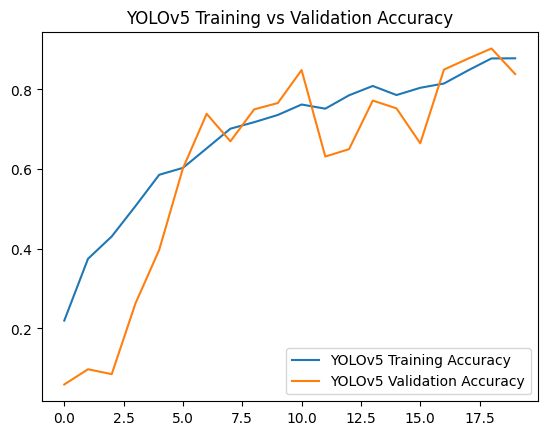

In [ ]:
# Visualize Training Progress
plt.plot(history_v5.history['accuracy'], label='YOLOv5 Training Accuracy')
plt.plot(history_v5.history['val_accuracy'], label='YOLOv5 Validation Accuracy')
plt.title('YOLOv5 Training vs Validation Accuracy')
plt.legend()
plt.show()

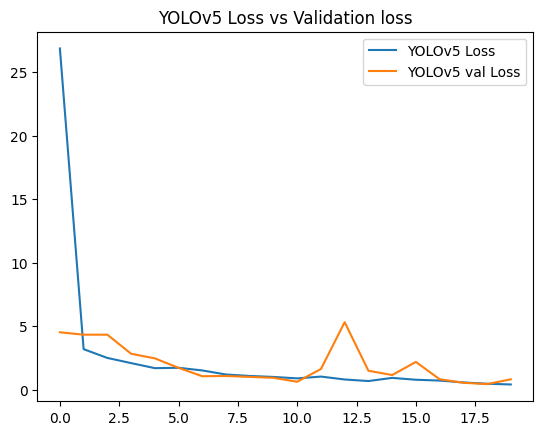

In [ ]:
# Visualize Training Progress
plt.plot(history_v5.history['loss'], label='YOLOv5 Loss')
plt.plot(history_v5.history['val_loss'], label='YOLOv5 val Loss')
plt.title('YOLOv5 Loss vs Validation loss')
plt.legend()
plt.show()

**V8**

In [ ]:
# YOLOv8 architecture (simplified)
def yolo_v8_baseline(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = yolo_conv_block(x, 128)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # YOLOv8 typically has even more depth and higher resolution capacity
    x = yolo_conv_block(x, 512)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
# Initialize YOLOv8 baseline
model_v8 = yolo_v8_baseline((IMG_SIZE, IMG_SIZE, 3), num_classes=len(labels_df))

In [ ]:
# Compile the model
model_v8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the YOLOv8 model
history_v8 = model_v8.fit(datagen.flow(X_train, y_train, batch_size=32),
                          validation_data=(X_test, y_test),
                          epochs=20)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 61s 428ms/step - accuracy: 0.0967 - loss: 104.4149 - val_accuracy: 0.0395 - val_loss: 8.9606
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step - accuracy: 0.2306 - loss: 7.3474 - val_accuracy: 0.0801 - val_loss: 5.0476
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.3306 - loss: 4.6668 - val_accuracy: 0.0308 - val_loss: 5.2956
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 303ms/step - accuracy: 0.4039 - loss: 4.1245 - val_accuracy: 0.1973 - val_loss: 4.5993
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.4862 - loss: 3.0235 - val_accuracy: 0.3477 - val_loss: 2.8971
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step - accuracy: 0.4754 - loss: 3.9262 - val_accuracy: 0.4291 - val_loss: 2.2678
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.5719 - loss: 2.5749 - val_accuracy: 0.4834 - val_loss: 2.1503
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 302ms/step - accuracy: 0.6076 - loss:

In [ ]:
# Save YOLOv8 model
model_v8.save('/content/drive/MyDrive/Data-Science-Projects/Traffic-Sign/yolov8_finetuned_model.h5')

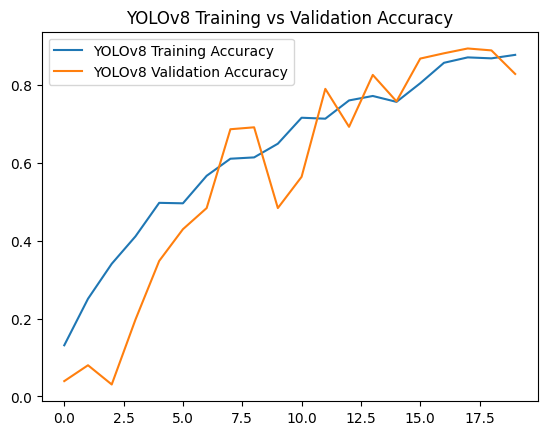

In [ ]:
# Visualize Training Progress
plt.plot(history_v8.history['accuracy'], label='YOLOv8 Training Accuracy')
plt.plot(history_v8.history['val_accuracy'], label='YOLOv8 Validation Accuracy')
plt.title('YOLOv8 Training vs Validation Accuracy')
plt.legend()
plt.show()

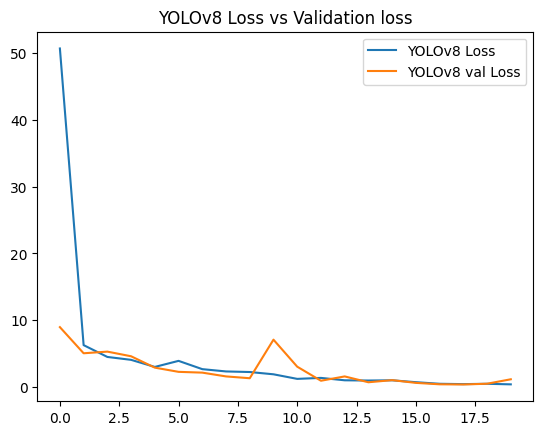

In [ ]:
# Visualize loss Progress
plt.plot(history_v8.history['loss'], label='YOLOv8 Loss')
plt.plot(history_v8.history['val_loss'], label='YOLOv8 val Loss')
plt.title('YOLOv8 Loss vs Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_v3 = model_finetuned.predict(X_test)
y_pred_v3 = np.argmax(y_pred_v3, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [ ]:
y_pred_v5 = model_v5.predict(X_test)
y_pred_v5 = np.argmax(y_pred_v5, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [ ]:
y_pred_v8 = model_v8.predict(X_test)
y_pred_v8 = np.argmax(y_pred_v8, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


In [ ]:
# Model accuracy comparison
models = ['YOLOv3', 'YOLOv5', 'YOLOv8']
acc_v3 = history_finetuned.history['val_accuracy'][-1]
acc_v5 = history_v5.history['val_accuracy'][-1]
acc_v8 = history_v8.history['val_accuracy'][-1]

accs = [acc_v3, acc_v5, acc_v8]

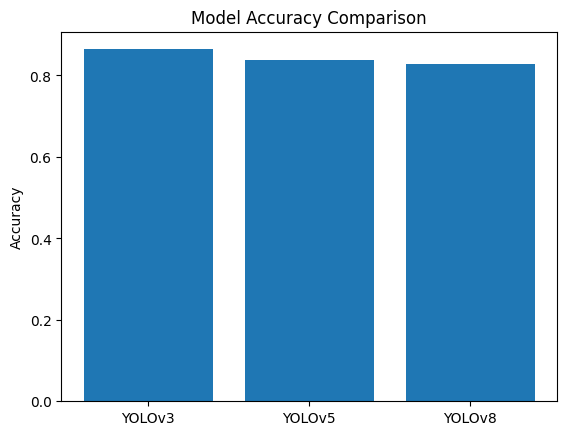

In [ ]:
plt.bar(models, accs)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Get the unique labels from the test data
unique_labels = np.unique(y_test)


In [ ]:
# Print classification reports for all three models for deeper comparison
print("YOLOv3 Classification Report:")
print(classification_report(y_test, y_pred_v3, labels=unique_labels, target_names=labels_df.loc[unique_labels, 'Name'].values))

YOLOv3 Classification Report:
                              precision    recall  f1-score   support

         Speed limit (5km/h)       0.76      0.92      0.83        24
        Speed limit (15km/h)       1.00      0.50      0.67         8
        Speed limit (30km/h)       0.83      0.94      0.88        16
        Speed limit (40km/h)       0.81      0.73      0.77        52
        Speed limit (50km/h)       0.95      0.95      0.95        20
        Speed limit (60km/h)       0.62      0.82      0.70        39
        Speed limit (70km/h)       1.00      0.81      0.90        16
        speed limit (80km/h)       0.75      0.60      0.67        30
    Dont Go straight or left       1.00      1.00      1.00         2
            Dont Go straight       0.74      1.00      0.85        14
                Dont Go Left       0.89      0.86      0.87        28
       Dont Go Left or Right       0.95      1.00      0.97        19
               Dont Go Right       0.62      0.71      0.67

In [ ]:
print("YOLOv5 Classification Report:")
print(classification_report(y_test, y_pred_v5, labels=unique_labels, target_names=labels_df.loc[unique_labels, 'Name'].values))

YOLOv5 Classification Report:
                              precision    recall  f1-score   support

         Speed limit (5km/h)       1.00      0.92      0.96        24
        Speed limit (15km/h)       1.00      0.38      0.55         8
        Speed limit (30km/h)       0.55      0.75      0.63        16
        Speed limit (40km/h)       0.62      0.69      0.65        52
        Speed limit (50km/h)       0.61      1.00      0.75        20
        Speed limit (60km/h)       0.94      0.44      0.60        39
        Speed limit (70km/h)       0.89      1.00      0.94        16
        speed limit (80km/h)       0.73      0.53      0.62        30
    Dont Go straight or left       1.00      1.00      1.00         2
            Dont Go straight       0.78      1.00      0.88        14
                Dont Go Left       0.81      0.93      0.87        28
       Dont Go Left or Right       1.00      1.00      1.00        19
               Dont Go Right       0.58      1.00      0.74

In [ ]:
print("YOLOv8 Classification Report:")
print(classification_report(y_test, y_pred_v8, labels=unique_labels, target_names=labels_df.loc[unique_labels, 'Name'].values))

YOLOv8 Classification Report:
                              precision    recall  f1-score   support

         Speed limit (5km/h)       0.85      0.92      0.88        24
        Speed limit (15km/h)       1.00      1.00      1.00         8
        Speed limit (30km/h)       0.83      0.62      0.71        16
        Speed limit (40km/h)       0.48      1.00      0.65        52
        Speed limit (50km/h)       0.87      0.65      0.74        20
        Speed limit (60km/h)       1.00      0.51      0.68        39
        Speed limit (70km/h)       0.79      0.69      0.73        16
        speed limit (80km/h)       0.00      0.00      0.00        30
    Dont Go straight or left       1.00      0.50      0.67         2
            Dont Go straight       1.00      0.93      0.96        14
                Dont Go Left       0.74      0.82      0.78        28
       Dont Go Left or Right       1.00      1.00      1.00        19
               Dont Go Right       0.86      0.86      0.86

In [ ]:
# Model comparison of key metrics
metrics = ['Precision', 'Recall', 'F1-Score']

precision_v3 = classification_report(y_test, y_pred_v3, output_dict=True)['weighted avg']['precision']
precision_v5 = classification_report(y_test, y_pred_v5, output_dict=True)['weighted avg']['precision']
precision_v8 = classification_report(y_test, y_pred_v8, output_dict=True)['weighted avg']['precision']

recall_v3 = classification_report(y_test, y_pred_v3, output_dict=True)['weighted avg']['recall']
recall_v5 = classification_report(y_test, y_pred_v5, output_dict=True)['weighted avg']['recall']
recall_v8 = classification_report(y_test, y_pred_v8, output_dict=True)['weighted avg']['recall']

f1_v3 = classification_report(y_test, y_pred_v3, output_dict=True)['weighted avg']['f1-score']
f1_v5 = classification_report(y_test, y_pred_v5, output_dict=True)['weighted avg']['f1-score']
f1_v8 = classification_report(y_test, y_pred_v8, output_dict=True)['weighted avg']['f1-score']

In [ ]:
comparison_df = pd.DataFrame({
    'Model': models,
    'Precision': [precision_v3, precision_v5, precision_v8],
    'Recall': [recall_v3, recall_v5, recall_v8],
    'F1-Score': [f1_v3, f1_v5, f1_v8]
})

print(comparison_df)


    Model  Precision    Recall  F1-Score
0  YOLOv3   0.883643  0.864365  0.863528
1  YOLOv5   0.876833  0.838471  0.838713
2  YOLOv8   0.844787  0.827374  0.816617


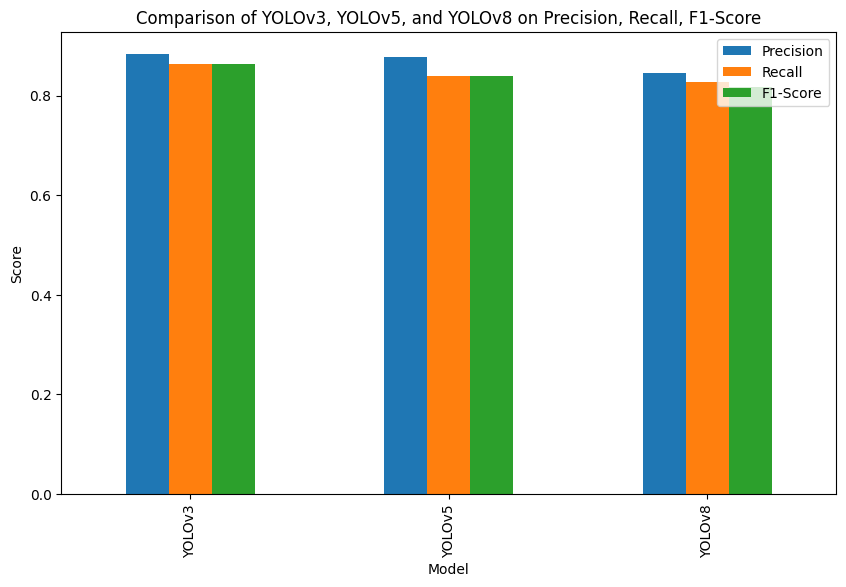

In [ ]:
# Visualizing Comparison
comparison_df.plot(x='Model', kind='bar', figsize=(10, 6))
plt.title('Comparison of YOLOv3, YOLOv5, and YOLOv8 on Precision, Recall, F1-Score')
plt.ylabel('Score')
plt.show()

In [ ]:
print("HI")

HI


In [ ]:
print("Done and Dusted")

Done and Dusted


In [ ]:
y_test

array([54, 11, 16,  5, 42, 30,  3, 13, 40,  2,  5, 15, 28, 28, 41,  0, 11,
       28, 28,  5, 15,  3, 38, 17, 14, 34,  4, 54, 28,  0, 12, 14, 48, 34,
       43,  4, 16, 23,  5, 12, 55, 28, 20, 24, 54, 36, 12, 54,  5, 11, 11,
       14, 54, 28, 35, 10, 35, 28, 37, 28, 50,  4, 28,  4,  2, 54,  0, 28,
       11,  5, 28, 30, 50, 26, 24,  0, 29, 35,  5, 28,  5,  5, 17, 30, 30,
       17, 26, 17, 30, 50, 35,  3, 30, 30, 28, 55,  5, 20, 14, 14, 54, 30,
       12, 35, 14,  0, 54,  7,  3,  7, 31, 26,  6,  6, 26,  3,  7, 35, 41,
       35, 28, 32, 55, 28, 54,  7,  3, 43, 11, 12,  3, 54, 28, 11, 43, 31,
        6, 37,  1, 55, 45,  5, 49,  7, 28,  4, 14, 11, 28, 31, 16, 28,  2,
       54,  6, 24, 28, 28, 16, 33,  4, 24, 26,  0, 14,  3, 24,  1, 11, 43,
        7, 28, 28, 41, 36, 44, 39, 17, 13, 28, 16, 18,  3,  4,  0, 35, 28,
       54, 34, 43, 54, 50,  7, 10, 54, 41, 28, 43,  0, 54, 17, 17, 44, 52,
       46, 35, 36,  5, 29, 26, 35, 55, 28, 16, 12, 43,  4, 20, 16, 55, 42,
       28, 50, 55, 54, 28

In [ ]:
y_pred_v3

array([54, 11, 16,  5, 42, 30,  5, 13, 40,  2,  5, 15, 28, 28, 42,  0, 11,
       28, 28,  3, 15,  5, 38, 17, 14, 34,  4, 54, 28,  0, 12, 14, 48, 34,
       45,  4, 16, 23,  3, 12, 55, 28, 20, 24, 54, 36, 12, 54,  5, 11, 11,
       14, 54, 28, 35, 10, 35, 28, 45, 28, 50,  4, 28,  4,  2, 54,  0, 28,
       13,  5, 28, 30, 50, 26, 24,  0, 29, 35,  7, 28,  5,  5, 17, 30, 30,
       17, 26, 17, 30, 50, 45,  3, 30, 30, 28, 55,  5, 20, 14, 14, 54, 30,
       12, 35, 10,  0, 54,  7,  3,  3, 31, 26,  6,  0, 26,  3,  5, 35, 41,
       43, 28, 32, 55, 28, 54,  3,  3, 43, 11, 12,  3, 54, 28, 11, 38, 31,
        6, 32,  1, 55, 45,  5, 22,  5, 28,  4, 14, 11, 28, 31, 16, 28,  2,
       54,  6, 24, 28, 28, 16, 33,  4, 24, 26,  0, 14,  3, 24,  0, 11, 45,
        7, 28, 28, 49, 36, 44, 38, 17, 11, 28, 16, 13,  3,  4,  0, 35, 28,
       54, 45, 43, 54, 50,  7, 10, 54, 42, 28, 43,  0, 54, 17, 17, 39, 52,
       46, 45, 36,  3, 29, 26, 35, 55, 28, 16, 12, 45,  4, 20, 16, 55, 42,
       28, 50, 55, 54, 28